In [1]:
import numpy as np
import pandas as pd

from utils import load_parquet_to_df_list, z_normalize, scale_min_max
from approximation.paa import PAA
from discretization.sax.sax import SAX
from discretization.sax.one_d_sax import OneDSAX, compute_slopes
from discretization.sax.adaptive_sax import AdaptiveSAX
from discretization.sax.extended_sax import ExtendedSAX
from discretization.persist.persist import Persist
from information_embedding_cost.information_loss import compute_information_loss, _compute_reconstructed_ts
from discretization.symbol_mapping import IntervalNormMedian, IntervalMean, MeanValuePoints, MedianValuePoints, EncodedMinMaxScaling

In [2]:
# load time series dataset into dataframe and z-normalize it
path = "../../../0_data/UCRArchive_2018/SwedishLeaf/train"
df_list = load_parquet_to_df_list(path)

# concatenate all time series to one dataframe, because they all have the same length
df_norm = pd.concat([z_normalize(df["signal"].to_frame()) for df in df_list], axis=1).iloc[:,:10]
df_norm

,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal
0,2.223633,1.879365,1.737821,1.849911,1.272420,1.855131,1.980311,1.256096,2.372685,1.757239
1,2.058567,1.733153,1.708888,1.756304,1.242152,1.699672,1.945595,1.177800,2.214034,1.623284
2,1.849589,1.579823,1.559112,1.599822,1.160121,1.447596,1.994798,1.032340,1.920566,1.469904
3,1.642328,1.402389,1.392660,1.426092,1.058091,1.250063,1.917555,0.878520,1.678298,1.317046
4,1.438219,1.257130,1.149077,1.273384,1.028827,1.098138,1.882779,0.893563,1.437475,1.163565
...,...,...,...,...,...,...,...,...,...,...
123,1.345195,1.162620,1.002372,1.193060,0.755275,1.037431,1.595726,0.942026,1.364450,1.123809
124,1.547908,1.314745,1.222534,1.343649,0.835097,1.199133,1.534958,0.956829,1.589209,1.274539
125,1.760490,1.500432,1.344060,1.516737,0.896891,1.402509,1.692896,1.077517,1.821819,1.428121
126,1.970141,1.657326,1.589952,1.672155,1.032240,1.634548,1.739579,1.112765,2.098101,1.582936


In [3]:
window_size = 5

alphabet_size = 6
alphabet_size_avg = 3
alphabet_size_slope = 2

In [4]:
df_paa = PAA(window_size).transform(df_norm)

In [5]:
sax = SAX(alphabet_size)
one_d_sax = OneDSAX(alphabet_size_avg, alphabet_size_slope)
a_sax = AdaptiveSAX(alphabet_size)
e_sax = ExtendedSAX(alphabet_size)
persist = Persist(alphabet_size, skip=5)

In [6]:
symbol_mapping = IntervalNormMedian(alphabet_size=sax.alphabet_size)
symbol_mapping = IntervalMean(lower_bound=-2)
symbol_mapping = MeanValuePoints(df_norm)
symbol_mapping = MedianValuePoints(df_norm)
symbol_mapping = EncodedMinMaxScaling()


df_slopes = compute_slopes(df_norm, window_size)
symbol_mapping_slope = IntervalMean(lower_bound=compute_slopes(df_norm, window_size).iloc[:, 0].min())

In [7]:
df_reconstructed_sax = _compute_reconstructed_ts(df_paa, df_norm, window_size, sax, df_breakpoints=None, scale_slopes=False, symbol_mapping=symbol_mapping)

<AxesSubplot: >

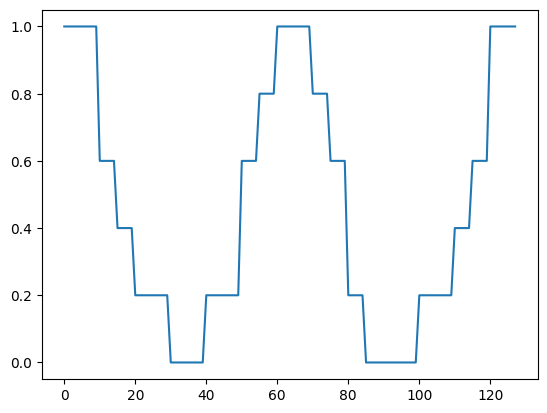

In [8]:
df_reconstructed_sax.iloc[:, 0].plot()

In [9]:
df_reconstructed_a_sax = _compute_reconstructed_ts(df_paa, df_norm, window_size, a_sax, df_breakpoints=None, scale_slopes=True, symbol_mapping=symbol_mapping)

<AxesSubplot: >

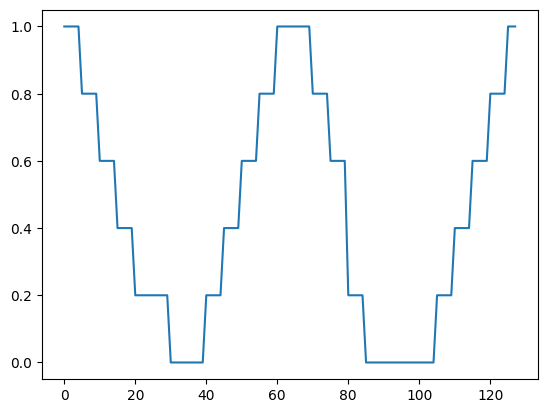

In [10]:
df_reconstructed_a_sax.iloc[:, 0].plot()

In [11]:
df_reconstructed_e_sax = _compute_reconstructed_ts(df_paa, df_norm, window_size, e_sax, df_breakpoints=None, scale_slopes=True, symbol_mapping_mean=symbol_mapping)

<AxesSubplot: >

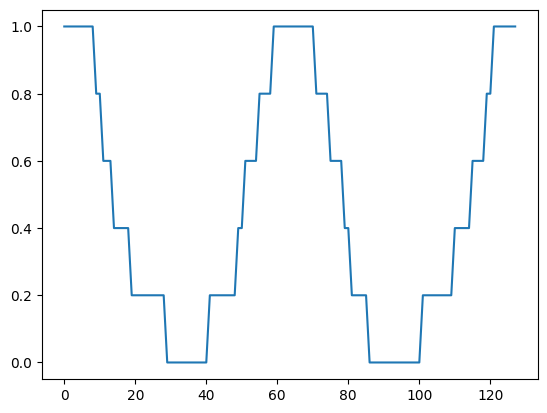

In [12]:
df_reconstructed_e_sax.iloc[:, 0].plot()

In [13]:
df_reconstructed_one_d_sax = _compute_reconstructed_ts(df_paa, df_norm, window_size, one_d_sax, df_breakpoints=None, scale_slopes=True,
                                                       symbol_mapping_avg=symbol_mapping, symbol_mapping_slope=symbol_mapping_slope)

<AxesSubplot: >

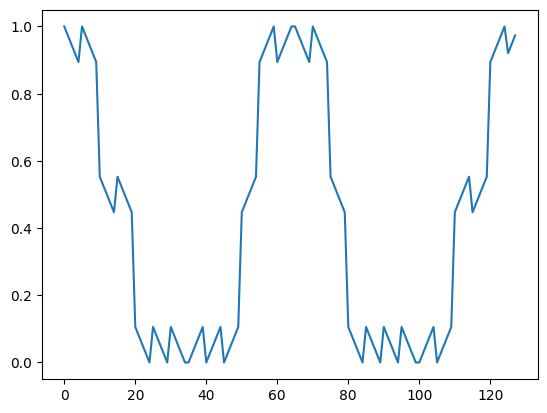

In [14]:
df_reconstructed_one_d_sax.iloc[:, 0].plot()

In [15]:
compute_information_loss(df_paa, df_norm, window_size, sax, symbol_mapping=symbol_mapping).mean()

0.019564381878957163

In [16]:
compute_information_loss(df_paa, df_norm, window_size, a_sax, symbol_mapping=symbol_mapping).mean()

0.01704893543027024

In [17]:
compute_information_loss(df_paa, df_norm, window_size, e_sax, symbol_mapping_mean=symbol_mapping).mean()

0.01815982120513897

In [18]:
compute_information_loss(df_paa, df_norm, window_size, one_d_sax, symbol_mapping_avg=symbol_mapping, symbol_mapping_slope=symbol_mapping_slope).mean()

0.03125654213968353

In [19]:
compute_information_loss(df_paa, df_norm, window_size, persist, symbol_mapping=symbol_mapping).mean()

0.019708549603143076